In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms, models
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


In [4]:
# Dataset path
data_dir = "E:/1 Paper Work/Cutting Tool Paper/Dataset/cutting tool data/test_data_40_images"

# Define transformations
# Define transformations with augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.RandomHorizontalFlip(p=0.5),  # Random horizontal flip
    transforms.RandomRotation(15),  # Random rotation
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),  # Color jitter
    transforms.ToTensor(),          # Convert images to tensors
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])


# Load dataset
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# Split dataset into training and testing sets
train_size = int(0.7 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Print class names and dataset sizes
print("Classes:", dataset.classes)
print(f"Training samples: {len(train_dataset)} (70%)")
print(f"Test samples: {len(test_dataset)} (30%)")


Classes: ['BF', 'BFI', 'GF', 'GFI', 'N', 'NI', 'TF']
Training samples: 196 (70%)
Test samples: 84 (30%)


In [5]:
class CNNLSTMHybrid(nn.Module):
    def __init__(self, num_classes):
        super(CNNLSTMHybrid, self).__init__()
        # Pre-trained ResNet18 (remove the fully connected layer)
        self.cnn = nn.Sequential(*list(models.resnet18(pretrained=True).children())[:-2])
        self.lstm_input_size = 512  # Feature size from ResNet18's last convolutional layer
        
        # LSTM layer with increased dropout
        self.lstm = nn.LSTM(self.lstm_input_size, hidden_size=256, num_layers=2, batch_first=True, dropout=0.4)
        
        # Fully connected layer for classification with increased dropout
        self.fc = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        batch_size, timesteps, C, H, W = x.size()
        c_in = x.view(batch_size * timesteps, C, H, W)  # Flatten batch and timesteps for CNN
        c_out = self.cnn(c_in)  # CNN output shape: [batch_size * timesteps, 512, 7, 7]
        
        # Global average pooling to reduce spatial dimensions
        c_out = torch.mean(c_out, dim=(2, 3))  # Shape: [batch_size * timesteps, 512]
        
        # Reshape for LSTM input
        c_out = c_out.view(batch_size, timesteps, -1)  # Shape: [batch_size, timesteps, 512]
        
        # Pass through LSTM
        lstm_out, _ = self.lstm(c_out)  # LSTM output shape: [batch_size, timesteps, 256]
        lstm_out = lstm_out[:, -1, :]  # Take the output of the last timestep
        
        # Fully connected layer
        output = self.fc(lstm_out)  # Shape: [batch_size, num_classes]
        return output


In [6]:
import torch
import torch.nn as nn

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Instantiate the model
num_classes = len(dataset.classes)
model = CNNLSTMHybrid(num_classes=num_classes).to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

# Check the model summary
print(model)


c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


CNNLSTMHybrid(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=Tru

In [7]:
def train_model(model, train_loader, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            # Add the temporal dimension
            inputs = inputs.unsqueeze(1)  # Add temporal dimension [batch_size, timesteps=1, channels, height, width]
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

        scheduler.step(total_loss / len(train_loader))
        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")


In [16]:
train_model(model, train_loader, num_epochs=10)


Epoch 1/10, Loss: 0.3743, Accuracy: 0.8980
Epoch 2/10, Loss: 0.3496, Accuracy: 0.9031
Epoch 3/10, Loss: 0.3115, Accuracy: 0.9286
Epoch 4/10, Loss: 0.4596, Accuracy: 0.8520
Epoch 5/10, Loss: 0.3258, Accuracy: 0.8980
Epoch 6/10, Loss: 0.4362, Accuracy: 0.9082
Epoch 7/10, Loss: 0.2906, Accuracy: 0.9184
Epoch 8/10, Loss: 0.2895, Accuracy: 0.9388
Epoch 9/10, Loss: 0.2963, Accuracy: 0.9337
Epoch 10/10, Loss: 0.2031, Accuracy: 0.9541


In [17]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            # Add the temporal dimension
            inputs = inputs.unsqueeze(1)  # Add temporal dimension [batch_size, timesteps=1, channels, height, width]
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds


Classification Report:
               precision    recall  f1-score   support

          BF       1.00      1.00      1.00         8
         BFI       1.00      0.90      0.95        10
          GF       0.85      1.00      0.92        11
         GFI       1.00      0.92      0.96        13
           N       0.90      0.75      0.82        12
          NI       0.83      1.00      0.91        15
          TF       1.00      0.93      0.97        15

    accuracy                           0.93        84
   macro avg       0.94      0.93      0.93        84
weighted avg       0.94      0.93      0.93        84



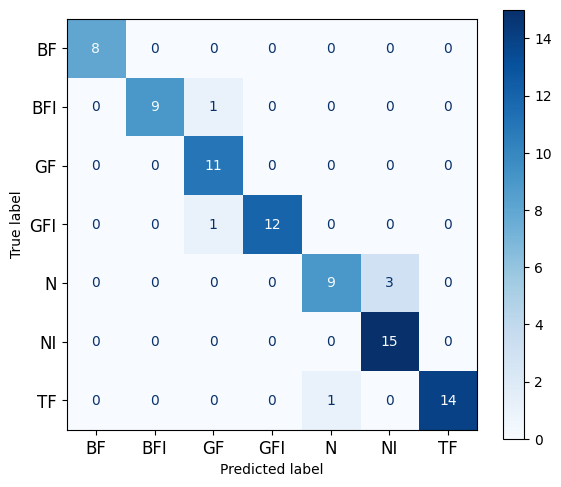

In [18]:
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.unsqueeze(1).to(device)  # Add temporal dimension
            labels = labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# Evaluate the model on the test dataset
test_preds, test_labels = evaluate_model(model, test_loader)

# Generate classification report
print("Classification Report:\n", classification_report(test_labels, test_preds, target_names=dataset.classes))

# Generate and plot confusion matrix
conf_matrix = confusion_matrix(test_labels, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=dataset.classes)

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap="Blues", ax=ax)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


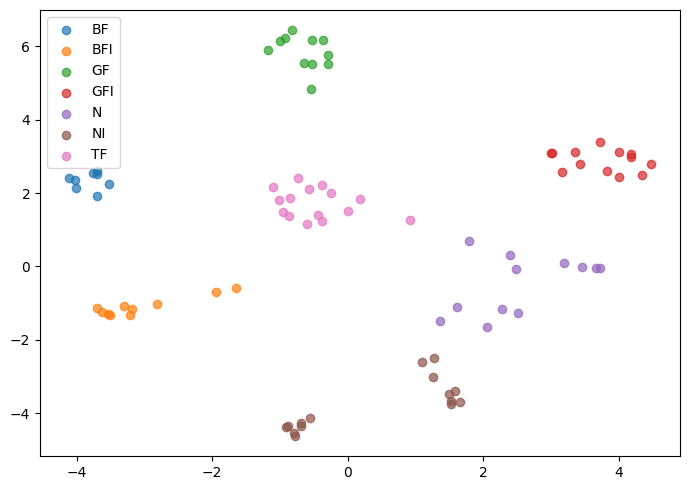

In [19]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def extract_features(model, dataloader, device):
    """
    Extract features using the CNN-LSTM hybrid model for t-SNE visualization.
    """
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            # Move inputs and targets to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Extract features using the CNN-LSTM
            batch_size = inputs.size(0)
            cnn_features = model.cnn(inputs)  # CNN features
            
            # Reshape CNN output for LSTM input
            lstm_input = cnn_features.view(batch_size, -1, cnn_features.size(1))
            
            # LSTM feature extraction
            lstm_out, _ = model.lstm(lstm_input)
            lstm_features = lstm_out[:, -1, :]  # Take the last time step
            
            # Collect features and labels
            features.append(lstm_features.cpu().numpy())
            labels.append(targets.cpu().numpy())
    
    features = np.vstack(features)
    labels = np.concatenate(labels)
    return features, labels

def plot_tsne(features, labels, class_names):
    """
    Plot t-SNE visualization of extracted features.
    """
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)
    
    plt.figure(figsize=(7, 5))
    
    for i, class_name in enumerate(class_names):
        idxs = labels == i
        plt.scatter(tsne_results[idxs, 0], tsne_results[idxs, 1], label=class_name, alpha=0.7)
    
    #plt.title("t-SNE Visualization of CNN-LSTM Features", fontsize=16)
    plt.legend(loc='best', fontsize=10)
    plt.tight_layout()
    plt.show()

# Extract features from the test dataset
test_features, test_labels = extract_features(model, test_loader, device)

# Plot t-SNE visualization
plot_tsne(test_features, test_labels, dataset.classes)


C:\Users\Muhammad Umar\AppData\Local\Temp\ipykernel_8736\3655829422.py:45: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20")
C:\Users\Muhammad Umar\AppData\Local\Temp\ipykernel_8736\3655829422.py:49: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(


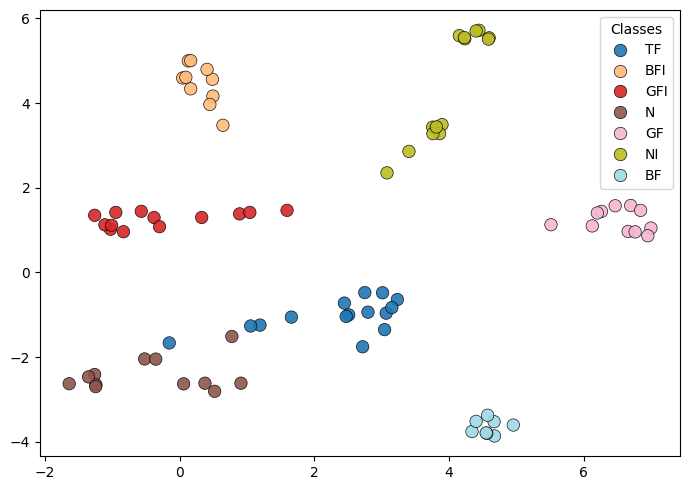

In [20]:
import torch
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def extract_features(model, dataloader, device):
    """
    Extract features using the CNN-LSTM hybrid model for t-SNE visualization.
    """
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            # Move inputs and targets to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Extract features using the CNN-LSTM
            cnn_features = model.cnn(inputs)  # CNN features
            batch_size = cnn_features.size(0)
            lstm_input = cnn_features.view(batch_size, -1, cnn_features.size(1))  # Reshape for LSTM
            lstm_out, _ = model.lstm(lstm_input)  # LSTM output
            lstm_features = lstm_out[:, -1, :]  # Take the last time step
            
            # Collect features and labels
            features.append(lstm_features.cpu().numpy())
            labels.append(targets.cpu().numpy())
    
    features = np.vstack(features)
    labels = np.concatenate(labels)
    return features, labels

def plot_tsne(features, labels, class_names):
    """
    Plot t-SNE visualization of extracted features.
    """
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(features)
    
    # Convert numeric labels to class names
    class_labels = [class_names[label] for label in labels]

    # Define the colormap
    cmap = plt.cm.get_cmap("tab20")

    # Plot the t-SNE results
    plt.figure(figsize=(7, 5))
    sns.scatterplot(
        x=tsne_results[:, 0],
        y=tsne_results[:, 1],
        hue=class_labels,
        palette=cmap(np.linspace(0, 1, len(class_names))),
        legend="full",
        s=80,
        alpha=0.9,
        edgecolor="black",
        linewidth=0.5
    )

    plt.legend(title="Classes", fontsize=10, loc='best')
    plt.tight_layout()
    #plt.savefig("results/2d_tsne_with_classes.png", dpi=300)  # Save as high-resolution image
    plt.show()

# Extract features from the test dataset
test_features, test_labels = extract_features(model, test_loader, device)

# Plot t-SNE visualization
plot_tsne(test_features, test_labels, dataset.classes)


c:\Users\Muhammad Umar\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


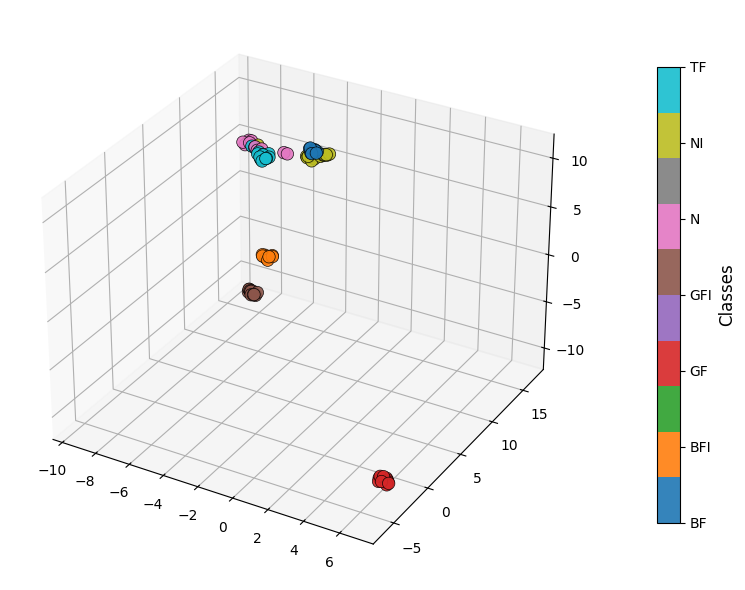

In [21]:
import umap
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

def extract_features_for_umap(model, dataloader, device):
    """
    Extract features using the CNN-LSTM hybrid model for UMAP visualization.
    """
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            # Move inputs and targets to device
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Extract features using the CNN-LSTM
            cnn_features = model.cnn(inputs)  # CNN features
            batch_size = cnn_features.size(0)
            lstm_input = cnn_features.view(batch_size, -1, cnn_features.size(1))  # Reshape for LSTM
            lstm_out, _ = model.lstm(lstm_input)  # LSTM output
            lstm_features = lstm_out[:, -1, :]  # Take the last time step
            
            # Collect features and labels
            features.append(lstm_features.cpu().numpy())
            labels.append(targets.cpu().numpy())
    
    features = np.vstack(features)
    labels = np.concatenate(labels)
    return features, labels

def plot_3d_umap(features, labels, class_names):
    """
    Plot 3D UMAP visualization of extracted features.
    """
    # Apply UMAP for 3D dimensionality reduction
    umap_model = umap.UMAP(n_components=3, random_state=42)
    umap_results = umap_model.fit_transform(features)
    
    # Create a 3D scatter plot
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter plot with class labels
    cmap = cm.tab10
    scatter = ax.scatter(
        umap_results[:, 0],
        umap_results[:, 1],
        umap_results[:, 2],
        c=labels,
        cmap=cmap,
        s=80,
        alpha=0.9,
        edgecolor="black",
        linewidth=0.5
    )

    # Add colorbar with class label mapping
    cbar = plt.colorbar(scatter, ax=ax, shrink=0.8, aspect=20, pad=0.1)
    cbar.set_label("Classes", fontsize=12)
    tick_locations = np.arange(len(class_names))
    cbar.set_ticks(tick_locations)
    cbar.set_ticklabels(class_names)

    # Axis labels


    # Save and display the plot
    plt.tight_layout()
    #plt.savefig("results/3d_umap_with_colorbar.png", dpi=300)
    plt.show()

# Extract features from the test dataset
test_features, test_labels = extract_features_for_umap(model, test_loader, device)

# Plot 3D UMAP visualization
plot_3d_umap(test_features, test_labels, dataset.classes)


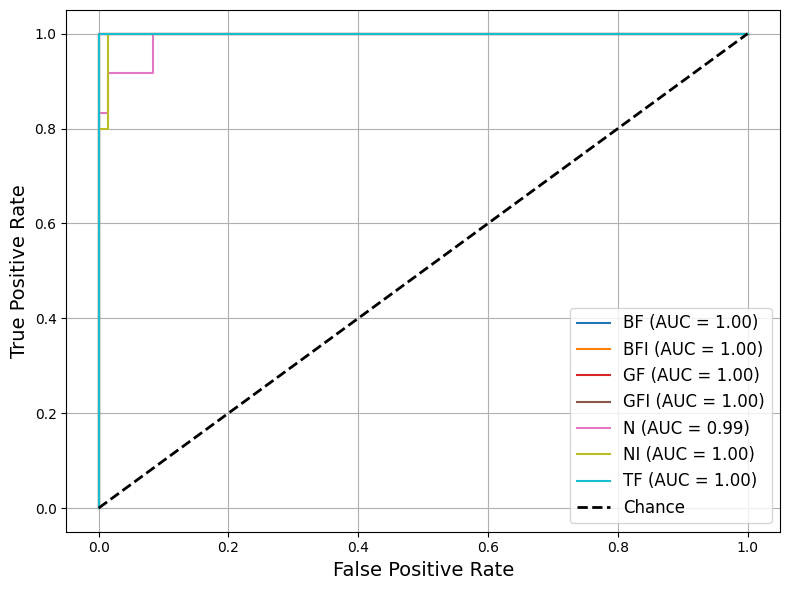

In [26]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

def plot_roc_curves_cnn_lstm(model, dataloader, class_names, device):
    """
    Plot ROC curves for a CNN-LSTM hybrid model.
    """
    model.eval()
    all_probs = []
    all_labels = []

    # Gather true labels and predicted probabilities
    with torch.no_grad():
        for inputs, labels in dataloader:
            # Add temporal dimension to the inputs
            inputs = inputs.unsqueeze(1).to(device)  # Add temporal dimension
            labels = labels.to(device)
            
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()  # Convert outputs to probabilities
            all_probs.append(probs)
            all_labels.append(labels.cpu().numpy())

    # Combine all batches
    all_probs = np.vstack(all_probs)
    all_labels = np.concatenate(all_labels)

    # Binarize labels for ROC curve computation
    y_true = label_binarize(all_labels, classes=range(len(class_names)))

    # Plot ROC curves for each class
    plt.figure(figsize=(8, 6))
    colors = plt.cm.tab10(np.linspace(0, 1, len(class_names)))

    for i, class_name in enumerate(class_names):
        fpr, tpr, _ = roc_curve(y_true[:, i], all_probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{class_name} (AUC = {roc_auc:.2f})', color=colors[i])

    # Plot the diagonal for reference
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance')

    # Customize the plot
    plt.xlabel('False Positive Rate', fontsize=14)
    plt.ylabel('True Positive Rate', fontsize=14)
    #plt.title('ROC Curves for Multi-Class Classification', fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid()
    plt.tight_layout()
    plt.show()

# Call the function to plot ROC curves
plot_roc_curves_cnn_lstm(model, test_loader, dataset.classes, device)
